# Segmenting and Clustering Neighborhoods in Toronto
## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. **First Part : Scraping the postal codes from Wikipedia**
    
    

2. **Second part : Adding the the latitude and the longitude coordinates of each neighborhood**
    
    

3. **Third part : Clustering Neighborhoods in Toronto**
   
</font>
</div>


## 1. First Part : Scraping the postal codes from Wikipedia
We download the libraries that we will need

In [207]:
import numpy as np
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup

We define the target url

In [59]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
url

'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

We read the web page, and extract it as a 'lxml' file

In [118]:
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'lxml')

We search the table onto the 'lxml' file

In [119]:
table = soup.find('table')

We then create a DataFrame from the above table

In [120]:
# We define the row
table_rows = table.find_all('tr')
l = []
# We iterate along the row
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
# We define the columns labels for the DataFrame
df = pd.DataFrame(l, columns=["PostalCode", "Borough", "Neighborhood"])
# We drop the '\n'
df["Neighborhood"] = df["Neighborhood"].str.strip('\n')
# We keep only the row for which the Borough have been assigned
df = df[df["Borough"] != 'Not assigned']
# We drop the first row 
df = df.iloc[1:,:].reset_index()[["PostalCode", "Borough", "Neighborhood"]]
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


We now clean and rearrange our DataFrame into a suitable form

In [126]:
# We group the Neighborhood by PostalCode
df = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(','.join).reset_index().sort_values(by='Borough')
# We assign the name of the Borough for not assigned Neighborhoods
df[df['Neighborhood'] == 'Not assigned']['Neighborhood'] = df['Borough']
df.head(20)

,PostalCode,Borough,Neighborhood
48,M4T,Central Toronto,"Moore Park,Summerhill East"
63,M5N,Central Toronto,Roselawn
47,M4S,Central Toronto,Davisville
64,M5P,Central Toronto,"Forest Hill North,Forest Hill West"
65,M5R,Central Toronto,"The Annex,North Midtown,Yorkville"
44,M4N,Central Toronto,Lawrence Park
45,M4P,Central Toronto,Davisville North
46,M4R,Central Toronto,North Toronto West
49,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,..."
50,M4W,Downtown Toronto,Rosedale


In [142]:
print('The number of rows of the DataFrame is',df.shape[0])

The number of rows of the DataFrame is 103


## 2. Second part : Adding the the latitude and the longitude coordinates of each neighborhood
We first read the CSV file containing the geolocalisation data

In [296]:
df_geo.head()


,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [164]:
# We add the geolocalisation data to our DataFrame
df = df.merge(df_geo)
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160
1,M5N,Central Toronto,Roselawn,43.711695,-79.416936
2,M4S,Central Toronto,Davisville,43.704324,-79.388790
3,M5P,Central Toronto,"Forest Hill North,Forest Hill West",43.696948,-79.411307
4,M5R,Central Toronto,"The Annex,North Midtown,Yorkville",43.672710,-79.405678


## 3. Third part : Clustering Neighborhoods in Toronto
We first vizualise all the neighborhoods in a map

In [171]:
#!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c conda-forge geopy --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0   conda-forge
    geopy:         1.21.0-py_0 conda-forge


geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [244]:
import folium
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

In [173]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="To_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [297]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{} - {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(map_toronto)  
    
map_toronto

In [237]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [238]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [239]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.shape

(101, 234)

In [240]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [255]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Seafood Restaurant,Asian Restaurant,Café,Hotel,Sushi Restaurant,Lounge,Restaurant,Smoke Shop,Speakeasy,Steakhouse
1,Agincourt,Breakfast Spot,Lounge,Latin American Restaurant,Skating Rink,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Playground,Park,Women's Store,Dessert Shop,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Pizza Place,Sandwich Place,Pharmacy,Airport Service,Diner,Farmers Market
4,"Alderwood,Long Branch",Pizza Place,Coffee Shop,Pub,Gym,Skating Rink,Dance Studio,Pharmacy,Sandwich Place,Pool,Athletics & Sports


Text(0, 0.5, 'Standard deviation of cluster density')

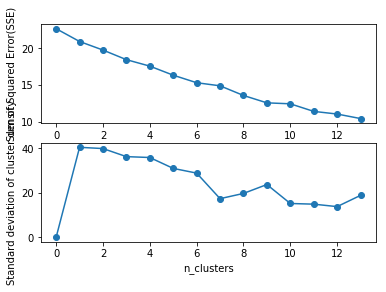

In [291]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

n_clusters_set = range(1,15)
k_means_intertias = []
stds = []

# find best k for k-means clustering
for n_clusters in n_clusters_set:
    kmeans = KMeans(n_clusters=n_clusters,random_state=0).fit(toronto_grouped_clustering)
    k_means_intertias.append(kmeans.inertia_)
    stds.append(np.std(np.bincount(kmeans.labels_)))

plt.subplot(2,1,1)
plt.plot(k_means_intertias,'-o')
plt.xlabel('n_clusters')
plt.ylabel('Sum of Squared Error(SSE)')
plt.subplot(2,1,2)
plt.plot(stds,'-o')
plt.xlabel('n_clusters')
plt.ylabel('Standard deviation of cluster density')

From the Elbow Criterion, the optimal k seem to be 6, but for k=7 the samples seem to be more uniformly cluster 

In [292]:
kmeans = KMeans(n_clusters=7,random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged['Cluster Labels'].replace(np.nan,0,inplace=True)# check the last columns!

In [294]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters